In [17]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

%matplotlib widget
plt.style.use('seaborn-v0_8-darkgrid')
plt.rc('xtick', labelsize=13)
plt.rc('axes', labelsize=13)
plt.rc('axes', titlesize=13)
plt.rc('legend', fontsize=13)

# Read Data from CSV

In [7]:
df = pd.read_csv('euribor_rates.csv', index_col='date')
df.index = pd.to_datetime(df.index)

display(df)
print(df.info())

,euribor_12_month,euribor_6_month,euribor_3_month,euribor_1_month
date,,,,
1999-01-04,3.209,3.223,3.234,3.242
1999-01-05,3.187,3.204,3.222,3.233
1999-01-06,3.176,3.197,3.214,3.226
1999-01-07,3.158,3.179,3.206,3.224
1999-01-08,3.139,3.166,3.196,3.217
...,...,...,...,...
2023-04-21,3.854,3.601,3.261,2.956
2023-04-22,3.854,3.601,3.261,2.956
2023-04-23,3.854,3.601,3.261,2.956


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8878 entries, 1999-01-04 to 2023-04-25
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   euribor_12_month  8878 non-null   float64
 1   euribor_6_month   8878 non-null   float64
 2   euribor_3_month   8878 non-null   float64
 3   euribor_1_month   8878 non-null   float64
dtypes: float64(4)
memory usage: 346.8 KB
None


# Plot historical Euribor rates

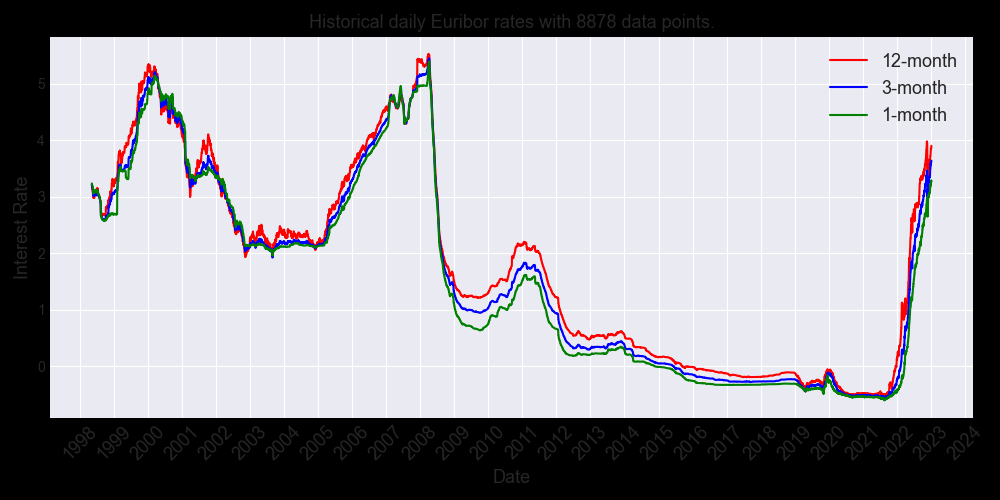

In [27]:
plt.figure('Historical Euribor rates', figsize=(10, 5))
plt.clf()

plt.plot(df['euribor_12_month'], color='red', label='12-month')
plt.plot(df['euribor_6_month'], color='blue', label='3-month')
plt.plot(df['euribor_3_month'], color='green', label='1-month')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=360))
plt.gca().xaxis.set_tick_params(rotation = 45) 

plt.legend()
plt.xlabel("Date")
plt.ylabel("Interest Rate [%]")
plt.title(f'Historical daily Euribor rates with {len(df)} data points.')
plt.tight_layout()

plt.show()

# Backtesting

In [4]:
def monthly_payment_annuety(N, r, T):
    '''
    N loan amoun, r interest rate, T loan maturity in years
    '''
    if r <= 0: r = 0.01
    return ((1 + r/12 / 100)**(T*12) * (r/12 / 100)) / ((1 + r/12 / 100)**(T*12) - 1) * N


def backtesting(rate_type, N, T):
    '''
    rate_type euribor [int], N loan amoun, T loan maturity in years
    '''
    if rate_type == 12:  period = 360; rate_col = 0
    elif rate_type == 6: period = 180; rate_col = 1
    elif rate_type == 3: period = 90;  rate_col = 2
    elif rate_type == 1: period = 30;  rate_col = 3
    else:
        raise ValueError('Invalid rate type')

    payments_list = []
    total_payments_list = []
    origination_date_list = []
    dates_list = []
    maturity_days = T*360
    for i in range(len(df)):
        if i+maturity_days >= len(df):
            break

        indexes = np.arange(i, i+maturity_days-1, period)
        rates = df.iloc[indexes, rate_col]
        indexes = np.arange(i, i+maturity_days-1, 30)
        dates = df.iloc[indexes].index - pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
        dates = dates.values.astype('datetime64[D]').tolist()
        dates_list += dates
        origination_date_list.append(df.index.values[i])
        payments = 0

        for j, rate in enumerate(rates):
            payment = monthly_payment_annuety(N, rate, T)
            payments += payment*rate_type
            payments_list += [payment]*rate_type
        total_payments_list.append(payments)

    return total_payments_list, origination_date_list, payments_list, dates_list

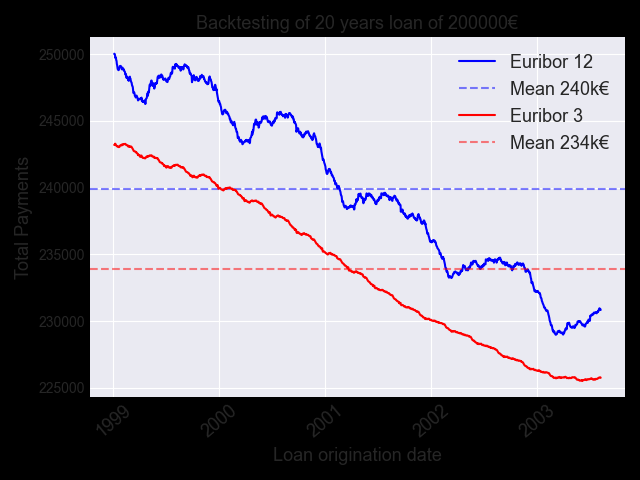

In [20]:
maturity = 20
loan_amount = 200000

plt.figure('Backtesting')
plt.clf()

toal_payments, origination_dates, payments, dates = backtesting(12, loan_amount, maturity)
plt.plot(origination_dates, toal_payments, color='blue', label='12-month')
plt.axhline(np.mean(toal_payments), c='blue', linestyle='--', alpha=0.5, label=f'Mean {np.mean(toal_payments)/1000:.0f}k€')

toal_payments, origination_dates, payments, dates = backtesting(3, loan_amount, maturity)
plt.plot(origination_dates, toal_payments, color='red', label='3-month')
plt.axhline(np.mean(toal_payments), c='red', linestyle='--', alpha=0.5, label=f'Mean {np.mean(toal_payments)/1000:.0f}k€')

plt.gca().xaxis.set_tick_params(rotation = 40) 
plt.legend()
plt.xlabel("Loan origination date")
plt.ylabel("Total Payments")
plt.title(f'Backtesting of {maturity} years loan of {loan_amount}€')
plt.tight_layout()
plt.show()

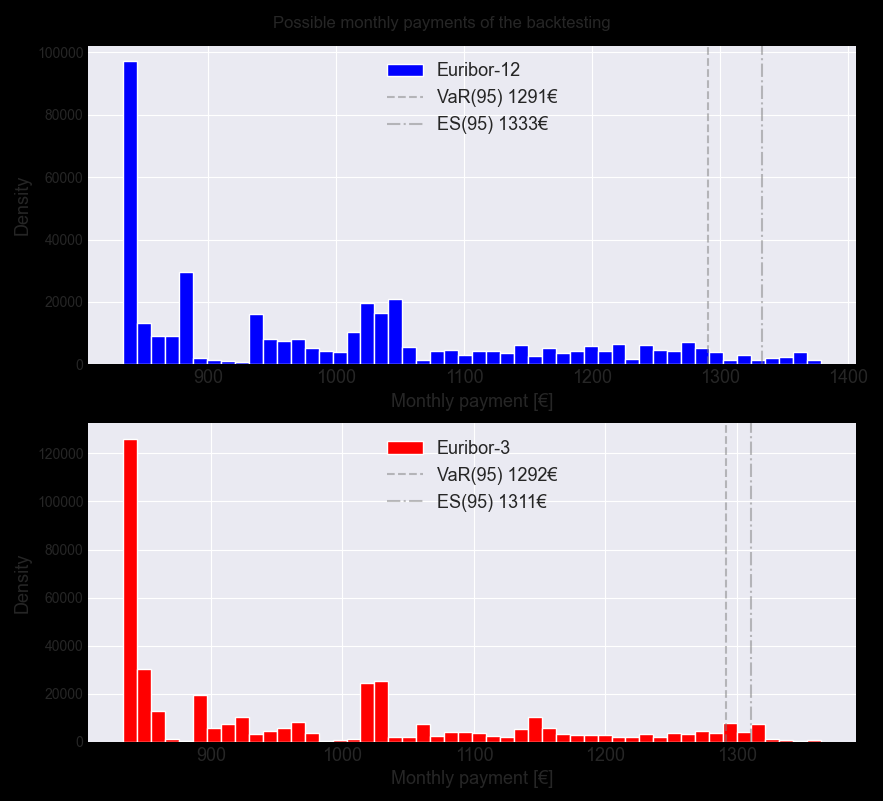

In [116]:
maturity = 20
loan_amount = 200000

plt.figure('VaR')
plt.clf()

plt.subplot(2, 1, 1)
toal_payments, origination_dates, payments, dates = backtesting(12, loan_amount, maturity)
plt.hist(payments, 50, color='blue', label='Euribor-12')
q95 = np.percentile(payments, 95)
plt.axvline(q95, c='grey', linestyle='--', alpha=0.5, label=f'VaR(95) {q95:.0f}€')
payments = np.array(payments)
es = np.mean(payments[payments >= q95])
plt.axvline(es, c='grey', linestyle='-.', alpha=0.5, label=f'ES(95) {es:.0f}€')
plt.legend()
plt.xlabel("Monthly payment [€]")
plt.ylabel("Density")

plt.subplot(2, 1, 2)
toal_payments, origination_dates, payments, dates = backtesting(3, loan_amount, maturity)
plt.hist(payments, 50, color='red', label='Euribor-3')
q95 = np.percentile(payments, 95)
plt.axvline(q95, c='grey', linestyle='--', alpha=0.5, label=f'VaR(95) {q95:.0f}€')
payments = np.array(payments)
es = np.mean(payments[payments >= q95])
plt.axvline(es, c='grey', linestyle='-.', alpha=0.5, label=f'ES(95) {es:.0f}€')
plt.legend()
plt.xlabel("Monthly payment [€]")
plt.ylabel("Density")

plt.suptitle(f'Possible monthly payments of the backtesting')
plt.tight_layout()
plt.show()

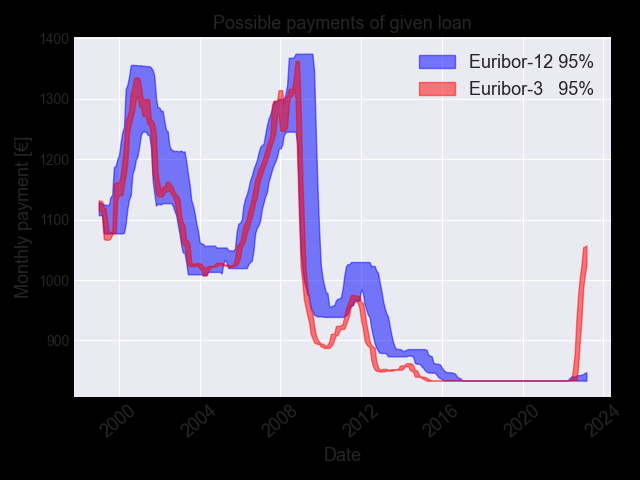

In [60]:
maturity = 20
loan_amount = 200000

plt.figure('Possible payments')
plt.clf()

# Euribor 12
toal_payments, origination_dates, payments, dates = backtesting(12, loan_amount, maturity)
plot_df = pd.DataFrame({'date': dates, 'payments': payments})
plot_df = plot_df.groupby(['date']).agg(median=('payments', 'median'), 
                                        lower_95=('payments', lambda x: np.quantile(x, q=0.025)), 
                                        upper_95=('payments', lambda x: np.quantile(x, q=0.975))).reset_index()

plt.fill_between(plot_df['date'], plot_df['lower_95'], y2=plot_df['upper_95'], color='blue', alpha=0.5, label='Euribor-12 95%')
#plt.plot(plot_df['date'], plot_df['median'], color='blue', label='Euribor12 median')

# Euribor 3
toal_payments, origination_dates, payments, dates = backtesting(3, loan_amount, maturity)
plot_df = pd.DataFrame({'date': dates, 'payments': payments})
plot_df = plot_df.groupby(['date']).agg(median=('payments', 'median'), 
                                        lower_95=('payments', lambda x: np.quantile(x, q=0.025)), 
                                        upper_95=('payments', lambda x: np.quantile(x, q=0.975))).reset_index()

plt.fill_between(plot_df['date'], plot_df['lower_95'], y2=plot_df['upper_95'], color='red', alpha=0.5, label='Euribor-3   95%')
#plt.plot(plot_df['date'], plot_df['median'], color='red', label='Euribor3 median')


plt.gca().xaxis.set_tick_params(rotation = 40) 
plt.legend()
plt.xlabel("Date")
plt.ylabel("Monthly payment [€]")
plt.title(f'Possible payments of given loan')
plt.tight_layout()
plt.show()

# Plot historical difference between 12 and 3-month Euribor rates

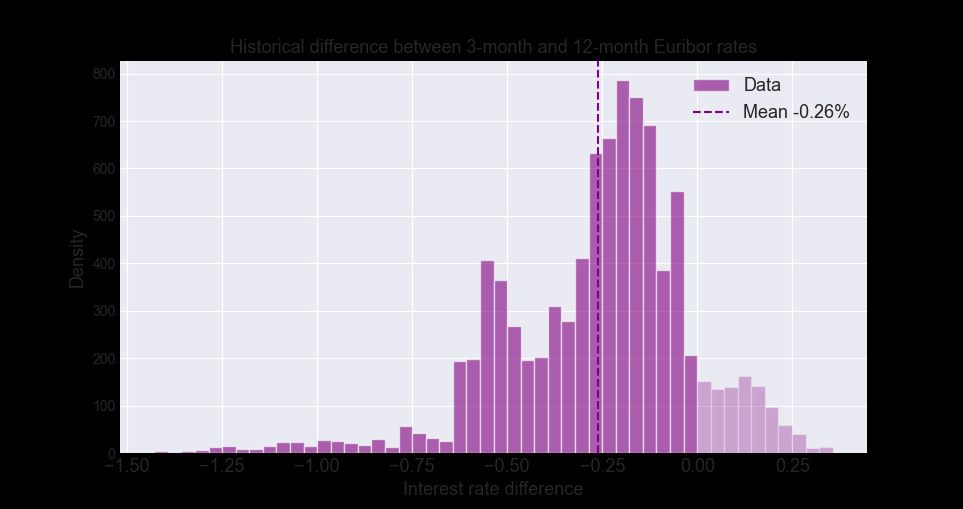

In [121]:
plt.figure('Historical difference')
plt.clf()

interest_diff = df['euribor_3_month'] - df['euribor_12_month']

n, bins, patches = plt.hist(interest_diff.values , 50, color='purple', alpha=0.6, label='Data')
z = np.linspace(0.0, 1.0, len(bins))
for i in range(len(bins[bins<=0])-1, len(bins)-1):
    patches[i].set_alpha(0.3)
mean = np.mean(interest_diff.values)
plt.axvline(mean, c='purple', linestyle='--', label=f'Mean {mean:.2f}%')

plt.legend()
plt.xlabel("Interest rate difference")
plt.ylabel("Density")
plt.title(f'Historical difference between 3-month and 12-month Euribor rates')
plt.show()



# Sampple Posterior distribution using Markov Chain Monte Carlo (MCMC), with No U Turn Sampler (NUTS)

In [94]:
def model_normal(true_events, false_events):
    theta = numpyro.sample('theta', dist.Beta(1, 1))
    y = numpyro.sample('y', dist.Binomial(probs=theta, total_count=true_events+false_events), obs=true_events)


def posterior_sampler(model_function, data):
    algo = NUTS(model_function)
    sampler = MCMC(algo, num_warmup=1000, num_samples=10000, num_chains=1)
    seed = jax.random.PRNGKey(0)
    sampler.run(seed, **data) 
    sample = sampler.get_samples()
    sampler.print_summary()
    return sample

In [95]:
data = {
    "true_events": interest_diff.loc[interest_diff < 0].count(),
    "false_events": interest_diff.loc[interest_diff >= 0].count()
}

sample = posterior_sampler(model_normal, data)

sample: 100%|██████████| 11000/11000 [00:08<00:00, 1294.57it/s, 7 steps of size 1.06e+00. acc. prob=0.92]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     theta      0.89      0.00      0.89      0.89      0.90   3127.17      1.00

Number of divergences: 0


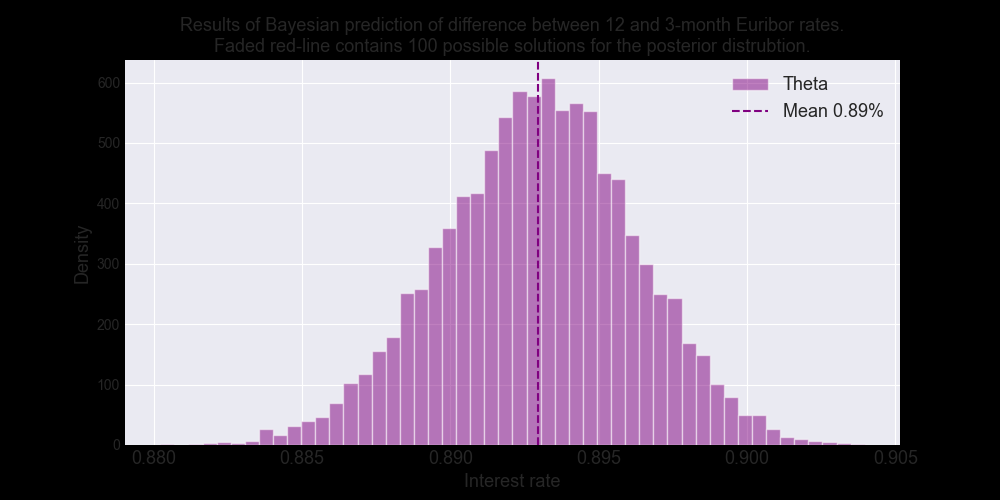

In [96]:
plt.figure(figsize=(10, 5))

plt.hist(sample['theta'], 50, color='purple', alpha=0.5, label='Theta')
mean = np.mean(sample['theta'])
plt.axvline(mean, c='purple', linestyle='--', label=f'Mean {mean:.2f}')

plt.legend()
plt.xlabel("Interest rate")
plt.ylabel("Density")
plt.title("Results of Bayesian prediction of difference between 12 and 3-month Euribor rates.\nFaded red-line contains 100 possible solutions for the posterior distrubtion.")
plt.show()

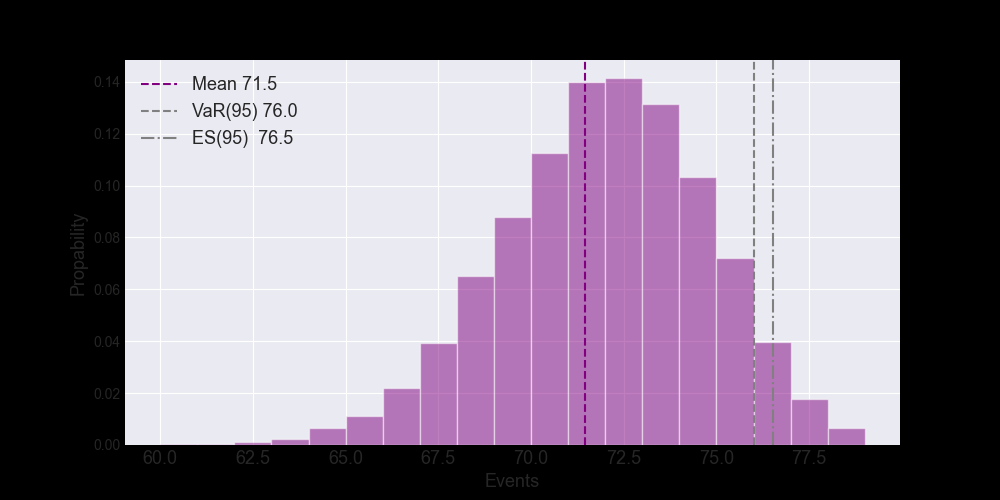

In [134]:
plt.figure('test', figsize=(10, 5))
plt.cla()
plt.clf()

outcomes =[]
for i in range(500):
    outcomes += np.random.binomial(n=4*MATURITY, p=sample['theta'][i], size=100).tolist()

weights = np.ones_like(outcomes)/float(len(outcomes))
bins = max(outcomes) - min(outcomes)
plt.hist(outcomes, bins, weights=weights, color='purple', alpha=0.5)

mean = np.mean(outcomes)
plt.axvline(mean, c='purple', linestyle='--', label=f'Mean {mean:.1f}')

q95 = np.percentile(outcomes, 95)
plt.axvline(q95, c='grey', linestyle='--', label=f'VaR(95) {q95:.1f}')
outcomes = np.array(outcomes)
es = np.mean(outcomes[outcomes >= q95])
plt.axvline(es, c='grey', linestyle='-.', label=f'ES(95)  {es:.1f}')

plt.legend()
plt.xlabel("Events")
plt.ylabel("Propability")
plt.title("")
plt.show()